# Forschungspraktikum SS20 
# Semantic Differentials for Wikipedia using the POLAR Framework


The POLAR Framework is a method that enables Interpretability for pre-trained word embeddings. The goal of this project is to produce word embeddings from a Wikipedia dataset, and deploy the POLAR framework to different categories of words (e.g. Countries, Politicians, Music, etc) in order to explain the semantic associations behind concepts on Wikipedia. An evaluation setup should assess the quality of the semantic differentials produced.

In [1]:

import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import multiprocessing
from gensim.corpora.wikicorpus import WikiCorpus #https://radimrehurek.com/gensim/corpora/wikicorpus.html
from gensim.models.word2vec import Word2Vec

# Only run next cell if a new Wikipedia dataset is loaded

In [3]:
from ipywidgets import interact, interactive, fixed, interact_manual

def myFunction(trainNewModel):
    return trainNewModel
print("Check if its your first time running this NodeBook")
trainNewModel=interact(myFunction, trainNewModel=True);

Check if its your first time running this NodeBook


interactive(children=(Checkbox(value=True, description='trainNewModel'), Output()), _dom_classes=('widget-inte…

In [16]:
trainNewModel=True
if trainNewModel==True:
    wiki = WikiCorpus(r"DataSets/enwiki-20200401-pages-articles1.xml-p1p30303.bz2", 
                  lemmatize=False, dictionary={})
    #stores the preprocessed dataset, which reduces runtime for the future
    wiki.save('SavedWord2Vec/wiki.corpus')
    
    sentences = list(wiki.get_texts()) #Iterate over the dump, yielding a list of tokens for each article that passed the length and namespace filtering.



/opt/anaconda3/lib/python3.7/site-packages/gensim/interfaces.py:96: UserWarning: corpus.save() stores only the (tiny) iteration object in memory; to serialize the actual corpus content, use e.g. MmCorpus.serialize(corpus)
  "corpus.save() stores only the (tiny) iteration object in memory; "


size: The number of dimensions of the embeddings and the default is 100.

window: The maximum distance between a target word and words around the target word. The default window is 5.

min_count: The minimum count of words to consider when training the model; words with occurrence less than this 
count will be ignored. The default for min_count is 5.

workers: The number of partitions during training and the default workers is 3.

sg: The training algorithm, either CBOW(0) or skip gram(1). The default training algorithm is CBOW.

In [17]:
### Compute the Word2Vec model usint following parameters#
# Currently using CBOW for testing because of performance issues of skip gram on my laptop #
if trainNewModel==True:
    print("Training Word2Vec model ...")
    params = {'size': 300, 'window': 5, 'min_count': 5, 
          'workers': max(1, multiprocessing.cpu_count() - 1), 'sample': 1E-3,'sg' : 1}
    word2vec = Word2Vec(sentences, **params)
    ### Save Word2Vec model to file ###
    word2vec.save('SavedWord2Vec/wiki.word2vec.model')
    print("Finished Training")
else:
    ### Loading finished Word2Vec model to memory from file ###
    print("Loading Word2Vec model from file...")
    word2vec = Word2Vec.load('SavedWord2Vec/wiki.word2vec.model')
    print("Finished Loading")


Training Word2Vec model ...
Finished Training


## King- Man + Woman = Queen?

In [18]:
def similarityNameVector(vec, name, model):
    
    cosineSimilarity = np.dot(vec, model.wv[name])/(np.linalg.norm(vec)* np.linalg.norm(model.wv[name]))
    return cosineSimilarity

#print(similarityNameVector(ourQueen,'queen'))



In [19]:
print("Smiliarity of king and queen:", word2vec.wv.similarity('king', 'queen'))
ourQueen= word2vec.wv['king'] - word2vec.wv['man'] + word2vec.wv['woman']
print("Smiliarity of transformed king and queen:", similarityNameVector(ourQueen,'queen',word2vec))

print("The most similar words to out transformation of King to Queen are:")
word2vec.wv.most_similar(positive=[ourQueen], topn=10) # cosine similarity
#word2vec.wv.most_similar(positive=["king"], topn=10)



Smiliarity of king and queen: 0.6234725
Smiliarity of transformed king and queen: 0.57965255
The most similar words to out transformation of King to Queen are:


[('king', 0.7423334717750549),
 ('queen', 0.5796525478363037),
 ('woman', 0.517516016960144),
 ('regnant', 0.5111746788024902),
 ('isabeau', 0.5028153657913208),
 ('throne', 0.5016829967498779),
 ('consort', 0.4985124170780182),
 ('chlothar', 0.48926517367362976),
 ('electress', 0.48813995718955994),
 ('theodelinda', 0.4879298210144043)]

In [20]:
ourJapan= word2vec.wv['france'] - word2vec.wv['paris'] + word2vec.wv['tokyo']
print("The most similar words to out transformation of France to Japan are:")
word2vec.wv.most_similar(positive=[ourJapan], topn=10) # cosine similarity
#word2vec.wv.most_similar(positive=["king"], topn=10)

The most similar words to out transformation of France to Japan are:


[('tokyo', 0.7715462446212769),
 ('japan', 0.7495639324188232),
 ('osaka', 0.6108940839767456),
 ('nagoya', 0.5861287117004395),
 ('kyushu', 0.5758974552154541),
 ('hyōgo', 0.5652197003364563),
 ('miyagi', 0.5611051321029663),
 ('ehime', 0.5560809373855591),
 ('saitama', 0.5548993349075317),
 ('ryukyu', 0.5532717704772949)]

## Usefull functions:

word2vec.wv.similarity('star', 'hollywood')  
word2vec.wv.most_similar('afghanistan')[:20]

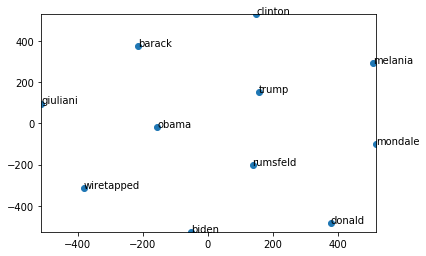

In [21]:
from sklearn.manifold import TSNE
def display_closestwords_tsnescatterplot(model, word, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.wv.similar_by_word(word)
    #print(arr)
    #print(np.array([model[word]]))
    arr = np.append(arr, np.array([model.wv[word]]), axis=0)
    
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
        plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
        plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

    
display_closestwords_tsnescatterplot(word2vec, 'trump', 300) 

# Online training / Resuming training

Advanced users can load a model and continue training it with more sentences and new vocabulary words:

model = gensim.models.Word2Vec.load(temporary_filepath)
more_sentences = [
    ['Advanced', 'users', 'can', 'load', 'a', 'model',
     'and', 'continue', 'training', 'it', 'with', 'more', 'sentences']
]
model.build_vocab(more_sentences, update=True)
model.train(more_sentences, total_examples=model.corpus_count, epochs=model.iter)

cleaning up temporary file
import os
os.remove(temporary_filepath)

## POLAR Framework code (https://github.com/Sandipan99/POLAR) :

In [22]:
import numpy as np
import gensim
from numpy import linalg

from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm_notebook as tqdm
import time
from random import shuffle
import sys
import nltk 
from nltk.corpus import wordnet 
import gc
from collections import defaultdict
import random
import json
import os

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath, get_tmpfile

from gensim.test.utils import datapath
#%load_ext autotime

In [23]:
current_model=model = word2vec

In [24]:
list_antonym = []

with open(r'Antonym_sets/LenciBenotto.val') as fp:
    for line in fp:
        parts = line.split()
        if parts[3]=='antonym':
            word1 = parts[0].split('-')[0]
            word2 = parts[1].split('-')[0]
            if word1 in current_model and word2 in current_model:
                list_antonym.append((word1.strip().lower(), word2.strip().lower()))


with open(r'Antonym_sets/LenciBenotto.test') as fp:
    for line in fp:
        parts = line.split()
        if parts[3]=='antonym':
            word1 = parts[0].split('-')[0]
            word2 = parts[1].split('-')[0]
            if word1 in current_model and word2 in current_model:
                list_antonym.append((word1.strip().lower(), word2.strip().lower()))
                
with open(r'Antonym_sets/EVALution.val') as fp:
    for line in fp:
        parts = line.split()
        if parts[3]=='antonym':
            word1 = parts[0].split('-')[0]
            word2 = parts[1].split('-')[0]
            if word1 in current_model and word2 in current_model:
                list_antonym.append((word1.strip().lower(), word2.strip().lower()))
                
with open(r'Antonym_sets/EVALution.test') as fp:
    for line in fp:
        parts = line.split()
        if parts[3]=='antonym':
            word1 = parts[0].split('-')[0]
            word2 = parts[1].split('-')[0]
            if word1 in current_model and word2 in current_model:
                list_antonym.append((word1.strip().lower(), word2.strip().lower()))
                
                
list_antonym = list(dict.fromkeys(list_antonym).keys())

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).


In [25]:
print(list_antonym[0:50])
print(len(list_antonym))

[('implicate', 'exclude'), ('assertion', 'rejection'), ('terminal', 'beginning'), ('lop', 'secure'), ('pastor', 'libertine'), ('pocket', 'hook'), ('orbital', 'stationary'), ('evidence', 'disprove'), ('psychological', 'biological'), ('preparedness', 'unprepared'), ('saturation', 'dehydration'), ('geologic', 'biologic'), ('accessibility', 'secured'), ('fight', 'agree'), ('lump', 'smooth'), ('double', 'half'), ('training', 'forgetting'), ('determined', 'negligent'), ('velocity', 'still'), ('shield', 'vulnerable'), ('measurement', 'guess'), ('iconic', 'ordinary'), ('thump', 'caress'), ('stretcher', 'compressor'), ('allude', 'distract'), ('cemetery', 'birthplace'), ('corrupt', 'sanctify'), ('cameraman', 'actor'), ('knowledgeable', 'uninformed'), ('screech', 'talk'), ('hedge', 'squander'), ('aggregate', 'please'), ('constrict', 'open'), ('make', 'break'), ('normative', 'descriptive'), ('inscribe', 'polish'), ('bulge', 'hollow'), ('edit', 'expand'), ('sensory', 'numb'), ('immobilize', 'move')

In [26]:
similarity_matrix = defaultdict(list)
print(similarity_matrix)
for each_pair in tqdm(list_antonym):
    word1 = each_pair[0]
    word2 = each_pair[1]
    #print(each_pair)
    #print(word1 < word2)
    
    if word1 < word2: ## welches wort länger ist
        similarity_matrix[word1].append(word2)                  #defaultdict(<class 'list'>, {'exclude': ['inscribe']})
        #print(similarity_matrix)
    else:
        similarity_matrix[word2].append(word1)
    
all_similarity = defaultdict(dict)
for each_key in tqdm(similarity_matrix):
    for each_value in similarity_matrix[each_key]:
#         cosine_similarity([current_model[each_key]]
        all_similarity[each_key][each_value] = abs(cosine_similarity([current_model.wv[each_key]],[current_model.wv[each_value]])[0][0])
        #print(current_model[each_key])
        #print(current_model[each_value])
        #print(all_similarity[each_key][each_value])
       
final_antonym_list = []
for index_counter, each_key in enumerate(tqdm(all_similarity)):
#     print(each_key,all_similarity[each_key])
    listofTuples = sorted(all_similarity[each_key].items() ,  key=lambda x: x[1])
    #print(listofTuples)
    final_antonym_list.append((each_key, listofTuples[0][0]))
 
print(final_antonym_list)

list_antonym = final_antonym_list

defaultdict(<class 'list'>, {})



[('exclude', 'inscribe'), ('assertion', 'lazy'), ('beginning', 'terminal'), ('lop', 'secure'), ('libertine', 'pastor'), ('hook', 'pocket'), ('orbital', 'stable'), ('disprove', 'document'), ('biological', 'psychological'), ('preparedness', 'unprepared'), ('dehydration', 'saturation'), ('biologic', 'geologic'), ('accessibility', 'secured'), ('agree', 'crab'), ('lump', 'spread'), ('double', 'indivisible'), ('forgetting', 'training'), ('determined', 'lazy'), ('still', 'velocity'), ('shield', 'vulnerable'), ('guess', 'measurement'), ('iconic', 'ordinary'), ('caress', 'punch'), ('compressor', 'stretcher'), ('allude', 'declare'), ('birthplace', 'cemetery'), ('corrupt', 'honor'), ('actor', 'cameraman'), ('knowledgeable', 'naive'), ('screech', 'talk'), ('hedge', 'plain'), ('aggregate', 'please'), ('constrict', 'free'), ('break', 'work'), ('descriptive', 'normative'), ('inscribe', 'polish'), ('bulge', 'thin'), ('edit', 'include'), ('numb', 'sensory'), ('immobilize', 'tour'), ('iodine', 'water')

In [27]:
print(len(list_antonym))

1409


In [28]:
num_antonym = 50#1468

In [29]:
## Find the antonym difference vectors
antonymy_vector = []
for each_word_pair in list_antonym:
    antonymy_vector.append(current_model.wv[each_word_pair[0]]- current_model.wv[each_word_pair[1]])
antonymy_vector = np.array(antonymy_vector)
print(antonymy_vector.shape)

(1409, 300)


In [30]:
print(list_antonym[2])

('beginning', 'terminal')


## Subset Dimension Selection Method

In [31]:
import random

from scipy.spatial.distance import cosine as scipy_cosine
random.seed(42)

t1 = np.array(antonymy_vector)
dimension_similarity_matrix = defaultdict(dict)
for index_1, each_dim1 in enumerate(tqdm(t1)):
    for index_2, each_dim2 in enumerate(t1):
        dimension_similarity_matrix[index_1][index_2] = abs(1-scipy_cosine(each_dim1, each_dim2))
        
        
def get_set_score(final_list, each_dim):
    final_output = 0.0
    for each_vec in final_list:
        final_output += dimension_similarity_matrix[each_vec][each_dim]
    return final_output/(len(final_list))
        
def select_subset_dimension(dim_vector, num_dim):
    working_list = np.array(dim_vector)
    
    working_position_index = [i for i in range(working_list.shape[0])]
    final_position_index = []
    

    print('working list is ready, shape', working_list.shape)
    sel_dim = random.randrange(0, working_list.shape[0])

    final_position_index.append(sel_dim)
    
    working_position_index.remove(sel_dim)

    
    for test_count in tqdm(range(num_dim-1)):
        min_dim = None
        min_score = 1000
        for temp_index, each_dim in enumerate(working_position_index):
#             print(each_dim)
            temp_score = get_set_score(final_position_index, each_dim)
            if temp_score< min_score:
                min_score= temp_score
                min_dim = each_dim
        print(test_count,min_dim)
        final_position_index.append(min_dim)
        working_position_index.remove(min_dim)
#         print(working_list.shape, len(final_list))
    return final_position_index

## Generate the ORTHOGONAL DIMENSION Order

## Generate the ORTHOGONAL DIMENSION Order

In [32]:
num_antonym = 50
orthogonal_antonymy_vector =np.array(select_subset_dimension(antonymy_vector, num_antonym))  
print(orthogonal_antonymy_vector.shape)
print(orthogonal_antonymy_vector)

working list is ready, shape (1409, 300)


0 528
1 636
2 188
3 351
4 453
5 554
6 1293
7 1245
8 1102
9 535
10 484
11 1246
12 382
13 83
14 1373
15 1129
16 940
17 1071
18 571
19 616
20 139
21 1350
22 582
23 874
24 155
25 1081
26 1387
27 1386
28 712
29 1128
30 213
31 830
32 1359
33 834
34 281
35 974
36 263
37 1323
38 891
39 769
40 1400
41 1099
42 1009
43 933
44 1197
45 917
46 888
47 733
48 552

(50,)
[1309  528  636  188  351  453  554 1293 1245 1102  535  484 1246  382
   83 1373 1129  940 1071  571  616  139 1350  582  874  155 1081 1387
 1386  712 1128  213  830 1359  834  281  974  263 1323  891  769 1400
 1099 1009  933 1197  917  888  733  552]


## Generate the RANDOM DIMENSION Order

## Generate the RANDOM DIMENSION Order

In [33]:
random_antonym_vector = [i for i in range(len(antonymy_vector))]
random.shuffle(random_antonym_vector)
print(len(random_antonym_vector))

1409


## Generate the MAXIMUM VARIANCE DIMENSION Order

## Generate the MAXIMUM VARIANCE DIMENSION Order

In [34]:
embedding_size = antonymy_vector.shape[0]   
print('The embedding size is', embedding_size)


variance_antonymy_vector_inverse = np.linalg.pinv(np.transpose(antonymy_vector))

embedding_matrix = []


total_words = 0
for each_word in tqdm(current_model.wv.vocab):
    total_words += 1

    new_vector = np.matmul(variance_antonymy_vector_inverse,current_model[each_word])
    
    embedding_matrix.append(new_vector)
print(total_words)

The embedding size is 1409


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  



147612


In [35]:
del new_vector

In [36]:
variance_list = []

embedding_matrix = np.array(embedding_matrix)

for each_dimension in tqdm(range(embedding_matrix.shape[1])):
    variance_list.append(np.var(embedding_matrix[:,each_dimension]))

In [37]:
variance_antonymy_vector = [each for each in sorted(range(len(variance_list)), key=lambda i: variance_list[i], reverse=True)]

In [38]:
del embedding_matrix

In [39]:
del variance_list

# Transformation to polar space

# Transformation to polar space

In [40]:
def transform_to_antonym_space(current_model, output_file_path, binary, current_antonymy_vector_inverse):
    embedding_size = orthogonal_antonymy_vector.shape[0] #current_antonymy_vector_inverse.shape[0]   ##CHANGE THIS ACCORDINGLY!!!
    print('New model size is',len(current_model.wv.vocab), embedding_size)

    temp_file = None
    
    if binary:
        temp_file = open(output_file_path,'wb')
        temp_file.write(str.encode(str(len(current_model.wv.vocab))+' '+str(embedding_size)+'\n'))
    else:
        temp_file = open(output_file_path,'w')
        temp_file.write(str(len(current_model.wv.vocab))+' '+str(embedding_size)+'\n')

    total_words = 0
    for each_word in tqdm(current_model.wv.vocab):
        total_words += 1
        if binary:
            temp_file.write(str.encode(each_word+' '))
        else:
            temp_file.write(each_word+' ')

        new_vector = np.matmul(current_antonymy_vector_inverse,current_model[each_word])

        new_vector = new_vector/linalg.norm(new_vector)

        
        
        if binary:
            temp_file.write(new_vector)
            temp_file.write(str.encode('\n'))
        else:
            temp_file.write(str(new_vector))
            temp_file.write('\n')


    temp_file.close()



# Standard normal transform 

In [41]:
def standard_normal_dist_model(model, new_filename):
    embedding_matrix = []
    embedding_vocab = []

    temp_file = open(new_filename,'wb')
    temp_file.write(str.encode(str(model.vectors.shape[0])+' '+str(model.vectors.shape[1])+'\n'))
    
    for each_word in tqdm(model.wv.vocab):
        embedding_matrix.append(model[each_word])
        embedding_vocab.append(each_word)
    
    embedding_matrix = np.array(embedding_matrix)
    
    print('The shape of embedding matrix is {}'.format(embedding_matrix.shape))
    
    norm_embedding_matrix = (embedding_matrix - embedding_matrix.mean(0))/ embedding_matrix.std(0)
    
    for word_counter, each_word in enumerate(tqdm(embedding_vocab)):
#         assert each_word==embedding_vocab[word_counter],'Not matching!!!'
        
        temp_file.write(str.encode(each_word+' '))
        new_vector = norm_embedding_matrix[word_counter]
        temp_file.write(new_vector)
        temp_file.write(str.encode('\n'))
        
    del embedding_matrix
    del embedding_vocab
    temp_file.close()

## Compute the task score for different dimension size

In [42]:
def generate_embedding_path(current_model, embedding_path, binary, antonym_vector, curr_dim):
    curr_antonym_vector = antonymy_vector[antonym_vector[:curr_dim]]
    curr_antonymy_vector_inverse = np.linalg.pinv(np.transpose(curr_antonym_vector))
    transform_to_antonym_space(current_model, embedding_path, binary,curr_antonymy_vector_inverse)

In [43]:
import subprocess
#dim_size = 500 # Number of POLAR dimenions
antonym_vector_method = orthogonal_antonymy_vector#random_antonym_vector # orthogonal_antonymy_vector, variance_antonymy_vector

In [44]:
curr_dim = len(antonym_vector_method)#dim_size

embedding_path = r'polarEmbedding'+str(curr_dim)+'.bin'
generate_embedding_path(current_model, embedding_path,True,antonym_vector_method, curr_dim)

print('loading the model')
temp_model = gensim.models.KeyedVectors.load_word2vec_format(embedding_path, binary=True)
print('loading done..')

std_nrml_embedding_path = r'polarEmbedding'+str(curr_dim)+'_StdNrml.bin'
standard_normal_dist_model(temp_model, std_nrml_embedding_path)



New model size is 147612 50


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



loading the model
loading done..


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  



The shape of embedding matrix is (147612, 50)


## Our Testing

In [45]:
#curr_dim=500
path=r'polarEmbedding'+str(curr_dim)+'_StdNrml.bin'
#f = open(path, "r+b")
#f.seek(0)
#print(f)
word2vecPolar = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)
print("Finished Loading")

Finished Loading


In [46]:
word2vecPolar["test"].shape

(50,)

In [47]:
word2vec.wv.most_similar(positive=["queen"], topn=10)

[('elizabeth', 0.6422714591026306),
 ('king', 0.6234725713729858),
 ('isabeau', 0.6121804714202881),
 ('ranavalona', 0.6099308133125305),
 ('margrethe', 0.6072167158126831),
 ('salote', 0.5936083793640137),
 ('consort', 0.5914666652679443),
 ('boleyn', 0.5876452922821045),
 ('regnant', 0.5866461992263794),
 ('isabella', 0.5862259864807129)]

In [48]:
word2vecPolar.wv.most_similar(positive=["angela"], topn=10)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('dunne', 0.6469331383705139),
 ('bauer', 0.6240968704223633),
 ('britt', 0.6171437501907349),
 ('haden', 0.6099597215652466),
 ('unger', 0.6065317392349243),
 ('mcgowan', 0.6034077405929565),
 ('liza', 0.6021282076835632),
 ('linda', 0.5909505486488342),
 ('bernadette', 0.5881332159042358),
 ('joanie', 0.5838892459869385)]

In [49]:
ourTokyo= word2vecPolar['king'] - word2vecPolar['man'] + word2vecPolar['woman']
print("The most similar words to out transformation of France to Japan are:")
word2vecPolar.most_similar(positive=[ourTokyo], topn=10) # cosine similarity
#word2vec.wv.most_similar(positive=["king"], topn=10)

The most similar words to out transformation of France to Japan are:


[('king', 0.6730219125747681),
 ('wives', 0.632933497428894),
 ('chaplain', 0.602401614189148),
 ('adelin', 0.5985189080238342),
 ('isabeau', 0.598315417766571),
 ('cynan', 0.5928754806518555),
 ('mpande', 0.5925252437591553),
 ('abdication', 0.5902350544929504),
 ('battenberg', 0.588743269443512),
 ('mingyi', 0.5829972624778748)]

In [50]:
#print(list_antonym)
count=0
for i in list_antonym:
    #print(type(i))
    if i == ('common', 'royal'):
        print(count)
    count+=1
print(list_antonym[1166])

1166
('common', 'royal')


In [51]:
orthogonal_antonymy_vector

array([1309,  528,  636,  188,  351,  453,  554, 1293, 1245, 1102,  535,
        484, 1246,  382,   83, 1373, 1129,  940, 1071,  571,  616,  139,
       1350,  582,  874,  155, 1081, 1387, 1386,  712, 1128,  213,  830,
       1359,  834,  281,  974,  263, 1323,  891,  769, 1400, 1099, 1009,
        933, 1197,  917,  888,  733,  552])

In [52]:
for i in orthogonal_antonymy_vector:
    print(list_antonym[i])

('stretch', 'tight')
('education', 'ignorance')
('detoxify', 'intoxicate')
('hurricane', 'sandstorm')
('give', 'pocket')
('listen', 'pontificate')
('deep', 'short')
('book', 'film')
('lyric', 'tune')
('blood', 'bone')
('distribution', 'single')
('arrive', 'leave')
('law', 'theory')
('fee', 'free')
('metropolitan', 'rural')
('cigarette', 'pipe')
('same', 'unique')
('bounce', 'roll')
('anger', 'happy')
('noticed', 'unnoticed')
('ion', 'neutron')
('anarchist', 'shah')
('dog', 'kitten')
('bowl', 'plate')
('horizontal', 'vertical')
('obituary', 'parody')
('nothing', 'play')
('sister', 'son')
('bathroom', 'bedroom')
('phagocyte', 'virus')
('wall', 'window')
('extrasensory', 'sensory')
('compact', 'huge')
('river', 'sea')
('meet', 'pass')
('confusing', 'instructive')
('begin', 'middle')
('beat', 'strum')
('both', 'one')
('cry', 'talk')
('management', 'workforce')
('royal', 'subject')
('closet', 'out')
('perfect', 'rubbish')
('dress', 'strip')
('party', 'work')
('float', 'sink')
('little', 'ta

In [53]:
#print(word2vecPolar["screenshot"])
word=word2vecPolar["water"]
print(word)
#print(list_antonym)
#print(orthogonal_antonymy_vector)
thisdict = {}

#indexedList=[]
for count, value in enumerate(word):
    thisdict[count]= value
#print(thisdict)

sortedDic=sorted(thisdict.items(), key=lambda item: abs(item[1]))
sortedDic.reverse()
#print(sortedDic)
for i in range(0,5):
    cur_Index=sortedDic[i][0]
    originalAntonymIndex=orthogonal_antonymy_vector[cur_Index]
    #print(originalAntonymIndex)
    print(sortedDic[i][1])
    print(list_antonym[originalAntonymIndex])
    #print(sortedDic[i])

[ 1.2102041   0.7581533   1.3748008  -0.34474754  0.5274994   0.37725416
  1.9020171   0.09485922 -0.6912016   2.1473606  -0.7792769  -0.3664923
  0.4407928  -1.0588706  -1.0448052  -1.1511118   1.001032    0.46194398
  0.03625355  0.9743986  -0.42772096 -0.2891685   0.2306617  -1.00256
 -0.78664064 -0.8664881   0.8028133  -0.14620614  1.1420616   1.7096393
 -0.42896435 -0.2834356  -1.3913168   0.09419071  0.5670788   0.01446837
  0.26767296  0.86108714  0.16002348  0.04139027  0.14620781  0.00667229
  0.1225685  -1.0028999  -1.0063103  -1.1985328   0.3312035  -0.71557474
 -0.22499683 -0.45097092]
2.1473606
('blood', 'bone')
1.9020171
('deep', 'short')
1.7096393
('phagocyte', 'virus')
-1.3913168
('compact', 'huge')
1.3748008
('detoxify', 'intoxicate')


In [54]:
import matplotlib.pyplot as pp
def getMeaningOfWord(strWord,antonymy_vector, model, numberPolar ):
    #print(antonymy_vector)
    word=model[strWord]
    thisdict = {}
    for count, value in enumerate(word):
        thisdict[count]= value
    sortedDic=sorted(thisdict.items(), key=lambda item: abs(item[1]))
    sortedDic.reverse()
   
    for i in range(0,numberPolar):
        cur_Index=sortedDic[i][0]
        originalAntonymIndex=antonymy_vector[cur_Index]
        #print(cur_Index)
        #print(originalAntonymIndex)
        #print(originalAntonymIndex)
        print(sortedDic[i][1])
        cur_value =sortedDic[i][1]
        leftPolar=list_antonym[originalAntonymIndex][0]
        rightPolar=list_antonym[originalAntonymIndex][1]
        plotPolar(rightPolar, leftPolar, cur_value)
    

In [55]:
def plotPolar(left, right, value):
    fig, ax1 = plt.subplots()
    fig.set_figheight(1)
    

    if abs(value)>10:
        fig.set_figwidth(20)
        ar = np.arange(-20,21)   
    else:
        fig.set_figwidth(10)
        ar = np.arange(-10,11)
    ax1.plot(ar, np.zeros_like(ar) + 0, '.')
    ax1.plot(value, 0, 'd', linewidth=2, markersize=20, color='r')
    ax1.set_ylabel(left, color='b',rotation=0, size=20, labelpad=50)
    ax1.set_yticks([])
    ax1.set_xticks(ar)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)

    ax2 = ax1.twinx()
    ax2.set_ylabel(right, color='r',rotation=0, size=20, labelpad=50)
    ax2.set_yticks([])
    ax1.grid(False)
    ax2.grid(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    
    
    
    fig.tight_layout()
    plt.show()

-1.8167638


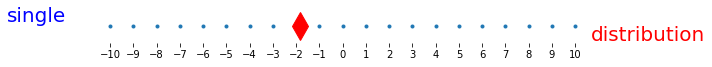

1.6990504


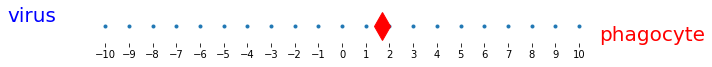

-1.4756956


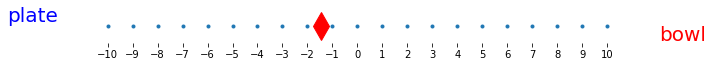

-1.4483595


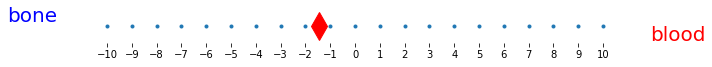

1.3713413


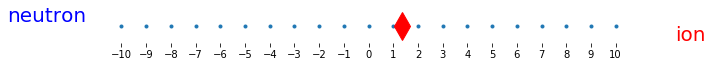

1.3469172


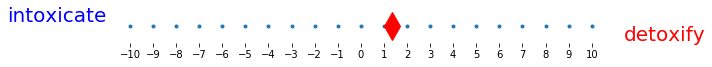

-1.1722696


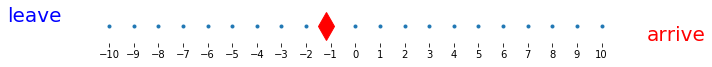

1.1343632


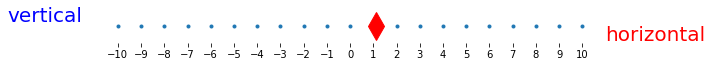

1.0744792


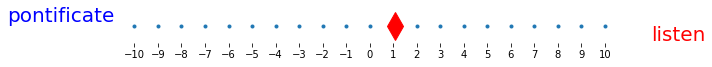

1.0703435


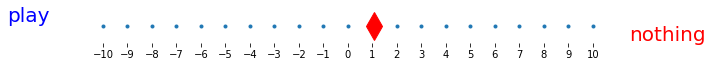

In [59]:
getMeaningOfWord("metal",orthogonal_antonymy_vector, word2vecPolar, 10 )

In [57]:
######### Task specific code....
command_list = ['python3', 
                    r'C:\Users\Jan\Desktop\PraktikumSS20\POLAR-master\Downstream Task\TREC\classify_task.py',
                     std_nrml_embedding_path,
                     '2',
                     r'C:\Users\Jan\Desktop\PraktikumSS20\POLAR-master\Downstream Task\TREC\data\qa_train_X.pickle',
                     r'C:\Users\Jan\Desktop\PraktikumSS20\POLAR-master\Downstream Task\TREC\data\qa_train_y.pickle',
                     r'C:\Users\Jan\Desktop\PraktikumSS20\POLAR-master\Downstream Task\TREC\data\qa_val_X.pickle',
                     r'C:\Users\Jan\Desktop\PraktikumSS20\POLAR-master\Downstream Task\TREC\data\qa_val_y.pickle',
                     r'C:\Users\Jan\Desktop\PraktikumSS20\POLAR-master\Downstream Task\TREC\data\qa_test_X.pickle',
                     r'C:\Users\Jan\Desktop\PraktikumSS20\POLAR-master\Downstream Task\TREC\data\qa_test_y.pickle'
                    ]



result = subprocess.run(command_list, stdout=subprocess.PIPE, shell=True)
print(result.stdout)
print('finished sentiment task')
################
del temp_model
    
os.remove(std_nrml_embedding_path)
os.remove(embedding_path)

b''
finished sentiment task
